* https://github.com/ieee8023/NeuralNetwork-Examples/blob/master/pytorch/pytorch-mnist.ipynb
* https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/transfer/transferlearning-vgg16-cifar10-1.ipynb (do this)

In [1]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt 

from torch.autograd import Variable
cuda = torch.cuda.is_available()

torch.manual_seed(0)
if cuda:
    torch.cuda.manual_seed(0)

In [2]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())

1
Tesla P100-PCIE-12GB
True


In [3]:
train = torchvision.datasets.MNIST('./data', train=True, download=True, transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test = torchvision.datasets.MNIST('./data', train=False, download=True, transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=10000,num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

train_data = train.train_data
train_data = train.transform(train_data.numpy())

/project/6037045/hasib/envs/pytorch/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [4]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc = nn.Linear(784, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        x = x.view((-1, 784))
        h = F.relu(self.fc(x))
        h = self.fc2(h)
        return F.log_softmax(h, dim=1)    
    
model = Model()
if cuda:
    model.cuda()
    
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [5]:
model

Model(
  (fc): Linear(in_features=784, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
)

In [6]:
EPOCHS = 100
losses = []


# Calculate the starting time    
start_time = time.time()

model.train()
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):

        data, target = Variable(data), Variable(target)
        
        if cuda:
            data, target = data.cuda(), target.cuda()
        
        optimizer.zero_grad()
        y_pred = model(data) 

        loss = F.cross_entropy(y_pred, target)
        losses.append(loss.cpu().data.item())
        loss.backward()
        optimizer.step()

        #if batch_idx % 100 == 1:
        print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch+1,
            EPOCHS,
            batch_idx * len(data), 
            len(train_loader.dataset),
            100. * batch_idx / len(train_loader), 
            loss.cpu().data.item()))

    evaluate_x = Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor()))
    evaluate_y = Variable(test_loader.dataset.test_labels)
    if cuda:
        evaluate_x, evaluate_y = evaluate_x.cuda(), evaluate_y.cuda()

    model.eval()
    output = model(evaluate_x)
    pred = output.data.max(1)[1]
    d = pred.eq(evaluate_y.data).cpu()
    accuracy = d.sum().item()*1./d.size()[0]
    
    print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Test Accuracy: {:.2f}%'.format(
        epoch+1,
        EPOCHS,
        len(train_loader.dataset), 
        len(train_loader.dataset),
        100. * batch_idx / len(train_loader), 
        loss.cpu().data.item(),
        accuracy*100.0))
    
    

end_time = time.time()
print("--- Time taken to train : %s hours ---" % ((end_time - start_time)//3600))

 Train Epoch: 1/100 [0/60000 (0%)]	Loss: 2.301791
 Train Epoch: 1/100 [10000/60000 (17%)]	Loss: 2.281525
 Train Epoch: 1/100 [20000/60000 (33%)]	Loss: 2.262006
 Train Epoch: 1/100 [30000/60000 (50%)]	Loss: 2.243166
 Train Epoch: 1/100 [40000/60000 (67%)]	Loss: 2.222155
 Train Epoch: 1/100 [50000/60000 (83%)]	Loss: 2.202597
 Train Epoch: 1/100 [60000/60000 (83%)]	Loss: 2.202597	 Test Accuracy: 51.54%


/project/6037045/hasib/envs/pytorch/lib/python3.6/site-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/project/6037045/hasib/envs/pytorch/lib/python3.6/site-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


 Train Epoch: 2/100 [0/60000 (0%)]	Loss: 2.180864
 Train Epoch: 2/100 [10000/60000 (17%)]	Loss: 2.163553
 Train Epoch: 2/100 [20000/60000 (33%)]	Loss: 2.141780
 Train Epoch: 2/100 [30000/60000 (50%)]	Loss: 2.121978
 Train Epoch: 2/100 [40000/60000 (67%)]	Loss: 2.102671
 Train Epoch: 2/100 [50000/60000 (83%)]	Loss: 2.082245
 Train Epoch: 2/100 [60000/60000 (83%)]	Loss: 2.082245	 Test Accuracy: 68.20%
 Train Epoch: 3/100 [0/60000 (0%)]	Loss: 2.060346
 Train Epoch: 3/100 [10000/60000 (17%)]	Loss: 2.045041
 Train Epoch: 3/100 [20000/60000 (33%)]	Loss: 2.021958
 Train Epoch: 3/100 [30000/60000 (50%)]	Loss: 2.000467
 Train Epoch: 3/100 [40000/60000 (67%)]	Loss: 1.981830
 Train Epoch: 3/100 [50000/60000 (83%)]	Loss: 1.961044
 Train Epoch: 3/100 [60000/60000 (83%)]	Loss: 1.961044	 Test Accuracy: 73.93%
 Train Epoch: 4/100 [0/60000 (0%)]	Loss: 1.943557
 Train Epoch: 4/100 [10000/60000 (17%)]	Loss: 1.919939
 Train Epoch: 4/100 [20000/60000 (33%)]	Loss: 1.891205
 Train Epoch: 4/100 [30000/60000 (

In [7]:
def plot_metric(vals):
    epochs = range(len(vals))
    plt.plot(epochs, vals, 'r')
    plt.title('Loss')
    plt.ylabel('Rate')
    plt.xlabel('Epoch')
    plt.legend(['loss'], loc='lower right', fontsize=10)
    plt.grid(True)
    plt.show()

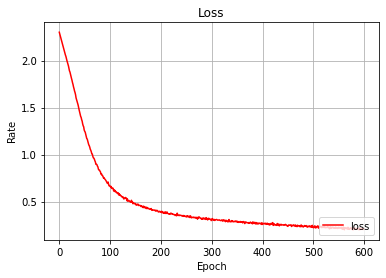

In [8]:
plot_metric(losses)